# `regionmask` for unstructured grids like `ICON`

- https://regionmask.readthedocs.io/en/latest/

In [1]:
#!pip install git+https://github.com/regionmask/regionmask.git@refs/pull/280/merge

In [2]:
import xarray as xr

In [53]:
xr.set_options(display_style='text')

In [62]:
path = '/work/bm1102/m211054/dyamond/zstar2/experiments/exp.ocean_era51h_zstar_r2b9_21223-DWS/outdata/exp.ocean_era51h_zstar_r2b9_21223-DWS_P1M_3d_20160901T000000Z.nc'
#path = '/work/mh0033/m211054/projects/icon/icon-oes-1.3.01/experiments/exp.ocean_era51h_r2b8_hel20218-ERA/outdata/exp.ocean_era51h_r2b8_hel20218-ERA_19970401T000000Z.nc'
ds = xr.open_dataset(path,
                     chunks={'depth': 16})

In [4]:
# use dask
from dask.distributed import Client
import multiprocessing
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 8
threads = ncpu // nworker
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}",
)
client = Client(
    processes=processes,
    threads_per_worker=threads,
    n_workers=nworker,
    memory_limit="64GB",
)
client

Number of CPUs: 72, number of threads: 9, number of workers: 8, processes: False


/work/mh0727/m300524/conda-envs/pymistral/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46379 instead
  warnings.warn(


<Client: 'inproc://10.50.43.213/54799/1' processes=8 threads=72, memory=476.84 GiB>

In [63]:
ds.coords

Coordinates:
  * time     (time) datetime64[ns] 2016-09-01
    clon     (ncells) float32 dask.array<chunksize=(14886338,), meta=np.ndarray>
    clat     (ncells) float32 dask.array<chunksize=(14886338,), meta=np.ndarray>
    elon     (ncells_2) float32 dask.array<chunksize=(22375924,), meta=np.ndarray>
    elat     (ncells_2) float32 dask.array<chunksize=(22375924,), meta=np.ndarray>
  * depth    (depth) float64 1.0 3.05 5.2 7.45 ... 5.522e+03 5.71e+03 5.904e+03
  * depth_2  (depth_2) float64 0.0 2.0 4.1 6.3 ... 5.615e+03 5.806e+03 6.003e+03

In [64]:
def rad_to_deg(ds):
    """Convert radian units to deg."""
    import numpy as np
    #ds.coords.compute()
    with xr.set_options(keep_attrs=True):
        for c in ds.coords:
            if 'units' in ds[c].attrs:
                if ds[c].attrs['units'] == 'radian':
                    print(f'convert {c} from rad to deg')
                    ds[c] = ds[c]* 180./np.pi
                    ds[c].attrs['units'] = 'degrees'
            elif 'bnds' in c:
                print(f'convert {c} from rad to deg')
                ds[c] = ds[c]* 180./np.pi
                ds[c].attrs['units'] = 'degrees'
    return ds

In [65]:
ds = rad_to_deg(ds)

convert clon from rad to deg
convert clat from rad to deg
convert elon from rad to deg
convert elat from rad to deg


In [66]:
ds = ds[['to']]

In [67]:
import regionmask

<GeoAxesSubplot:>

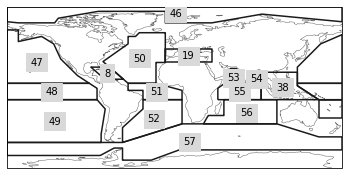

In [68]:
region = regionmask.defined_regions.ar6.ocean
region.plot()

In [69]:
%time mask = region.mask(ds,lon_name='clon', lat_name='clat', wrap_lon=False)

CPU times: user 33.5 s, sys: 1.91 s, total: 35.4 s
Wall time: 35.8 s


In [12]:
import dask

In [70]:
%time ds_region = ds.groupby(mask).mean('ncells')

/work/mh0727/m300524/conda-envs/pymistral/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/work/mh0727/m300524/conda-envs/pymistral/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return se

CPU times: user 20.9 s, sys: 3.98 s, total: 24.9 s
Wall time: 24.9 s


In [71]:
ds_region.to

<xarray.DataArray 'to' (region: 15, time: 1, depth: 128)>
dask.array<concatenate, shape=(15, 1, 128), dtype=float32, chunksize=(1, 1, 16), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2016-09-01
  * depth    (depth) float64 1.0 3.05 5.2 7.45 ... 5.522e+03 5.71e+03 5.904e+03
  * region   (region) float64 8.0 19.0 38.0 46.0 47.0 ... 54.0 55.0 56.0 57.0

In [72]:
%time ds_region = ds_region.compute()

CPU times: user 41.7 s, sys: 29.2 s, total: 1min 10s
Wall time: 41.2 s


- `R2B8`: 35s + 24s + 17s
- `R2B9`: 35s + 24s + 39s

In [73]:
ds_region = ds_region.assign_coords(names=('region',region.names))

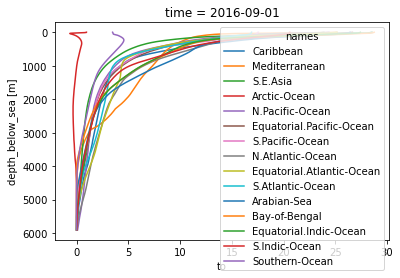

In [74]:
ds_region.swap_dims({'region':'names'}).to.plot(y='depth',hue='names',yincrease=False)

# zonal

In [75]:
import numpy as np

In [91]:
# create 1 deg lat * 180 deg lon regions
z=list()
names=list()
lat_stride=1
step=lat_stride-0.0001
for y in np.arange(-90,90,lat_stride):
    z.append(np.array([[-180, y], [-180, y+step], [180, y], [180, y+step]]))
    names.append(f'{y+lat_stride/2}')

region = regionmask.Regions(z, names=names, name='zonal_1deg')

<GeoAxesSubplot:>

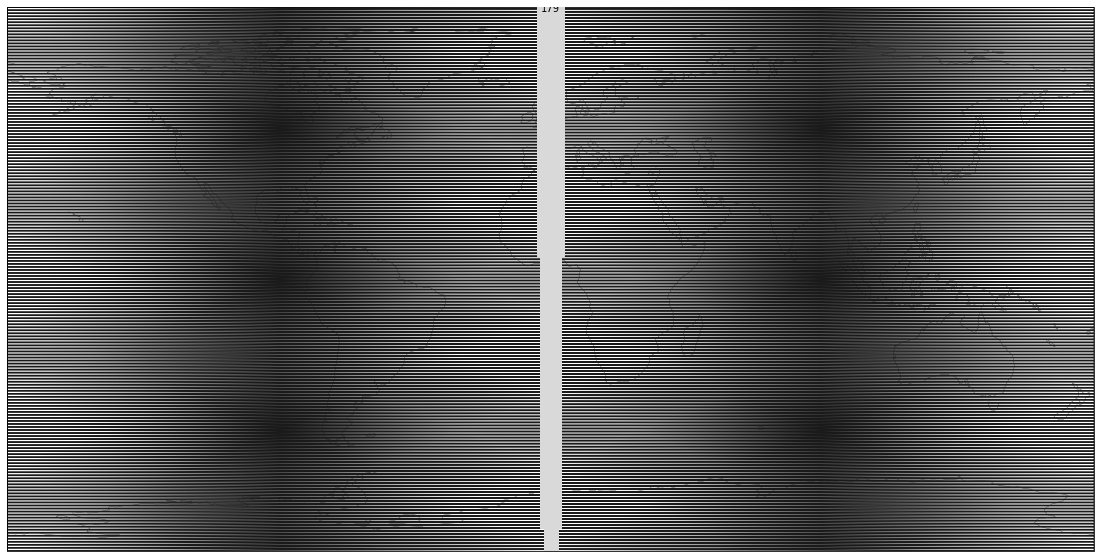

In [92]:
import matplotlib.pyplot as plt
plt.figure(figsize=(35,10))
region.plot()

In [93]:
region

<regionmask.Regions>
Name:     zonal_1deg

Regions:
  0   r0 -89.5
  1   r1 -88.5
  2   r2 -87.5
  3   r3 -86.5
  4   r4 -85.5
..   ...   ...
175 r175  85.5
176 r176  86.5
177 r177  87.5
178 r178  88.5
179 r179  89.5

[180 regions]

In [79]:
%time mask = region.mask(ds, wrap_lon=False, lon_name='clon', lat_name='clat')

CPU times: user 5min 55s, sys: 17.1 s, total: 6min 12s
Wall time: 6min 12s


In [80]:
mask # something like a weights file

<xarray.DataArray 'region' (ncells: 14886338)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * ncells   (ncells) int64 0 1 2 3 4 ... 14886334 14886335 14886336 14886337
    lat      (ncells) float32 72.14 72.12 72.17 72.12 ... -45.17 -45.23 -45.23
    lon      (ncells) float32 73.0 73.12 73.0 72.88 ... 76.5 76.49 76.54 76.45

In [85]:
%time zonal = ds.groupby(mask).mean()

/work/mh0727/m300524/conda-envs/pymistral/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


CPU times: user 17.7 s, sys: 12.2 s, total: 29.9 s
Wall time: 29.9 s


In [100]:
zonal = zonal.rename({'region':'lat'})
zonal = zonal.assign_coords(lat=zonal.lat-89.5)

In [101]:
%time zonal = zonal.compute()

CPU times: user 45.2 s, sys: 24.6 s, total: 1min 9s
Wall time: 37.8 s


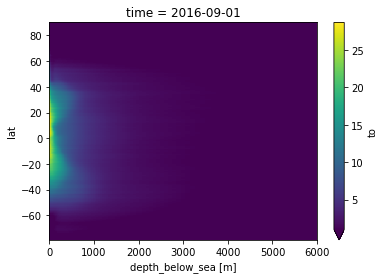

In [102]:
zonal.to.plot(robust=False, cmap='viridis',vmin=1)

In [ ]:
# without regionmask

In [126]:
# mask based on integer latitude, essentially the same as above
%time mask2 = ds.clat.round(0).compute()

CPU times: user 395 ms, sys: 202 ms, total: 597 ms
Wall time: 504 ms


In [124]:
%time zonal2 = ds.groupby(mask2).mean()

CPU times: user 20.8 s, sys: 24.8 s, total: 45.6 s
Wall time: 45.7 s


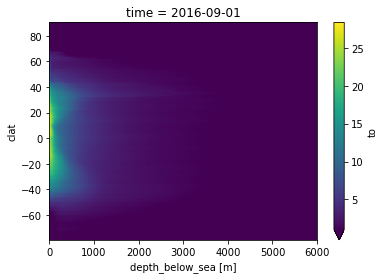

In [125]:
zonal2.to.plot(robust=False, cmap='viridis',vmin=1)